In [ ]:
# default_exp datasets
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# Small Random Toy Directed Graphs

In this notebook, we will create several small and random toy directed graphs and visualize them directly. We will test any embedding and visualization methods on these datasets to check if the embeddings/visualization matches our intuition about the flow on the small directed graphs.

In [5]:
# export
import warnings
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_sparse import SparseTensor
from torch_geometric.utils import remove_self_loops

class SmallRandom(InMemoryDataset):
  def __init__(self, num_nodes=5, prob_edge=0.2, transform=None, pre_transform=None):
    super().__init__(".", transform, pre_transform)

    if num_nodes > 30:
      num_nodes = 30
      warnings.warn("Number of nodes is too large for SmallRandom dataset. Reset num_nodes = ", num_nodes)
    
    dense_adj = (torch.rand((num_nodes, num_nodes)) < prob_edge).int()
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    if self.pre_transform is not None:
      data = self.pre_transform(data)
    self.data, self.slices = self.collate([data])


Let try creating one such graph

In [6]:
from directed_graphs.datasets import SmallRandom
dataset = SmallRandom(num_nodes=20, prob_edge=0.2)
data = dataset[0] # there is only graph in this dataset

Let try visualizing the directed graph directly and with a heat map.

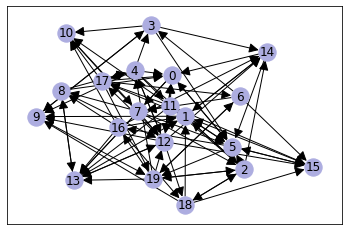

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph(data):
  G = to_networkx(data, to_undirected=False)
  nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), arrowsize=20, node_color="#adade0")
  plt.show()

visualize_graph(data)

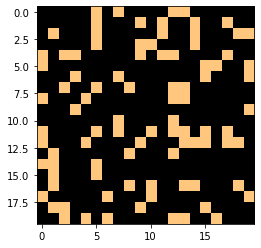

In [8]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj

def visualize_heatmap(edge_index, order_ind=None):
  dense_adj = to_dense_adj(edge_index)[0]
  if order_ind is not None:
    dense_adj = dense_adj[order_ind,:][:,order_ind]
  plt.imshow(dense_adj, cmap="copper")
  plt.show()

visualize_heatmap(data.edge_index)

It is also possible to create source and sink nodes using the same `SourceSink` transformation to generate small directed graph with specific characteristic. We will try transforming the graph above into a big cluster of source and a smaller cluster of sinks

In [12]:
from directed_graphs.datasets import SmallRandom, SourceSink
pre_transform = SourceSink(prob_source=0.6, prob_sink=0.4, adv_prob=0.1, remove_prob=0)
dataset = SmallRandom(num_nodes=20, prob_edge=0.2, pre_transform=pre_transform)
data = dataset[0]

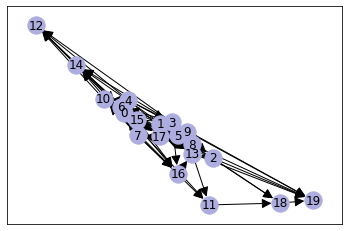

In [13]:
visualize_graph(data)

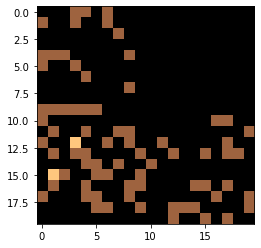

In [14]:
order_ind = torch.argsort(data.y[:,1])
visualize_heatmap(data.edge_index, order_ind)

From the heatmap alone we can clearly see 2 cluster of nodes, one acts as a source and one acts a sink.